<a href="https://colab.research.google.com/github/nikita-0209/stock_price_detection/blob/master/Stock_Prediction_Single_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd

In [0]:
import numpy as np

In [7]:
import keras

Using TensorFlow backend.


In [0]:
#Dataset
downloaded = drive.CreateFile({'id':"12f9gd7u5hGDwWEZgOd-O9iMkM6lE9vF-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stock_prices_sample.csv')        # replace the file name with your file

In [0]:
df=pd.read_csv('stock_prices_sample.csv')

# Prepare Data

In [10]:
df

,TICKER,FIGI,DATE,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
0,GEF,BBG000BLFQH8,2013-01-04,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
1,GEF,BBG000BLFQH8,2013-01-03,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2,GEF,BBG000BLFQH8,2013-01-02,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
3,GF,BBG000C3C6S2,2018-06-05,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
4,GF,BBG000C3C6S2,2018-06-04,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,GF,BBG000C3C6S2,2014-06-27,EOD,daily,18.63,18.6300,18.51,18.61,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0
995,GF,BBG000C3C6S2,2014-06-26,EOD,daily,18.52,18.5901,18.42,18.53,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0
996,GF,BBG000C3C6S2,2014-06-25,EOD,daily,18.66,18.7200,18.59,18.60,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0
997,GF,BBG000C3C6S2,2014-06-24,EOD,daily,18.91,18.9500,18.83,18.83,35200.0,11.893669,11.918828,11.843352,11.843352,35200.0,NaN,0.0,1.0


In [0]:
def get_year(date):
  year=date.split('-')[0]
  return year

In [0]:
df['Year']=df['DATE'].apply(get_year)

In [0]:
df = df[df['Year'] != '2013']

In [14]:
df

,TICKER,FIGI,DATE,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO,Year
3,GF,BBG000C3C6S2,2018-06-05,Intraday,daily,18.86,18.9100,18.8700,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0,2018
4,GF,BBG000C3C6S2,2018-06-04,EOD,daily,18.86,18.8900,18.7900,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0,2018
5,GF,BBG000C3C6S2,2018-06-01,EOD,daily,18.58,18.7600,18.5800,18.74,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,NaN,0.0,1.0,2018
6,GF,BBG000C3C6S2,2018-05-31,EOD,daily,18.52,18.5200,18.3012,18.49,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0,2018
7,GF,BBG000C3C6S2,2018-05-30,EOD,daily,18.47,18.6780,18.4700,18.65,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,GF,BBG000C3C6S2,2014-06-27,EOD,daily,18.63,18.6300,18.5100,18.61,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0,2014
995,GF,BBG000C3C6S2,2014-06-26,EOD,daily,18.52,18.5901,18.4200,18.53,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0,2014
996,GF,BBG000C3C6S2,2014-06-25,EOD,daily,18.66,18.7200,18.5900,18.60,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0,2014
997,GF,BBG000C3C6S2,2014-06-24,EOD,daily,18.91,18.9500,18.8300,18.83,35200.0,11.893669,11.918828,11.843352,11.843352,35200.0,NaN,0.0,1.0,2014


In [0]:
data=df[ ['DATE', 'OPEN']]

In [0]:
#Reverse Order of Data
data=data.iloc[::-1]

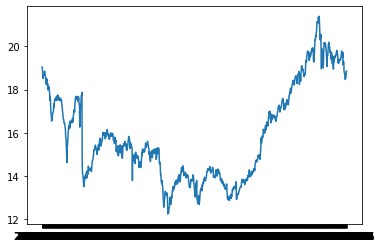

In [17]:
plt.plot(data['DATE'], data['OPEN'])

In [0]:
split_time=850

In [0]:
values=np.array(df['OPEN'])

In [0]:
train_df=data.iloc[:split_time]

In [0]:
train_values=train_df['OPEN']
train_values=np.array(train_values)

In [22]:
train_values.shape

(850,)

In [23]:
train_df.shape

(850, 2)

In [0]:
valid_df=data.iloc[split_time:]

In [25]:
valid_df.shape

(146, 2)

In [0]:
valid_values=valid_df['OPEN']
valid_values=np.array(valid_values)

In [0]:
series= np.concatenate((train_values, valid_values), axis=0)

# Single NN

In [0]:
window_size=20

In [0]:
batch_size = 32

In [0]:
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(train_values, window_size, batch_size, shuffle_buffer_size)

In [0]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

In [34]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.41376227],
       [-0.19228184],
       [-0.04039971],
       [ 0.45614475],
       [-0.23958087],
       [-0.38513786],
       [ 0.4310005 ],
       [-0.16625531],
       [ 0.04615141],
       [ 0.21800031],
       [ 0.12110663],
       [-0.04336675],
       [ 0.3346267 ],
       [-0.19870676],
       [-0.4531796 ],
       [ 0.3611122 ],
       [ 0.3349175 ],
       [ 0.32246163],
       [-0.5215755 ],
       [ 0.2017047 ]], dtype=float32), array([-0.00141019], dtype=float32)]


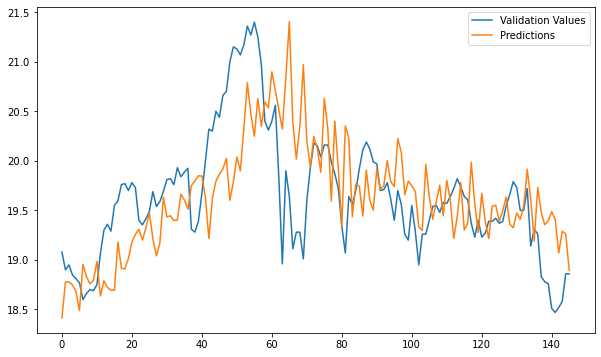

In [39]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(valid_values, label='Validation Values')
plt.plot(results, label='Predictions')
plt.legend()

# Error when I shuffled

In [36]:
tf.keras.metrics.mean_absolute_error(valid_values, results).numpy()

0.44344926

# Error When I did Not Shuffle

In [37]:
tf.keras.metrics.mean_absolute_error(valid_values, results).numpy()

0.44344926